In [2]:
from __future__ import division
from builtins import zip, range
from pybasicbayes.abstractions import GibbsSampling
import numpy as np
from warnings import warn

__all__ = ['Dynamic_GLM']



def sample_polya_gamma(b, c):
    """
    Simulate a Polya-Gamma distributed random variable using an approximation.
    b: Positive integer or float, the shape parameter.
    c: Real number, the scaling parameter.
    """
    shape = 0.5 * b
    scale = 1 / (2 * np.cosh(c / 2))
    return np.random.gamma(shape, scale)


def sample_polya_gamma_vector(b_vec, c_vec):
    """
    Vectorized Polya-Gamma sampler for multiple inputs.
    """
    return np.array([sample_polya_gamma(b, c) for b, c in zip(b_vec, c_vec)])


# Alternative PolyaGamma
print("Using alternative Polya-Gamma sampler.")
ppgs = sample_polya_gamma_vector


def local_multivariate_normal_draw(x, sigma, normal):
    """
    Function to combine pre-drawn Normals (normal) with the desired mean x and variance sigma (calls to multivariate normal are too costly)
    Cholesky doesn't like 0 cov matrix, but we want it.

    This might need changing if in practice we see plenty of 0 matrices.
    """
    try:
        return x + np.linalg.cholesky(sigma).dot(normal)
    except np.linalg.LinAlgError:
        if np.isclose(sigma, 0).all():
            return x
        else:
            print("Unusual covariance matrix")
            quit()


class Dynamic_GLM(GibbsSampling):
    """
    This class enables a drifting input-output GLM with logistic link function.

    States are thus dynamic logistic regressions. This class implements this observation distribution for a single state.

    Hyperparameters:
        n_regressors: number of regressors for the GLM
        T: number of timesteps (sessions)
        prior_mean: mean of regressors at the beginning (usually 0 vector)
        P_0: variance of regressors at the beginning
        Q: variance of regressors between timesteps (can be different across steps, but we use the same matrix throughout)
        jumplimit: for how many timesteps after last being used are the state weights allowed to change
    """

    def __init__(self, n_regressors, T, prior_mean, P_0, Q, jumplimit=1):
        assert jumplimit > 0

        self.n_regressors = n_regressors
        self.T = T
        self.jumplimit = jumplimit
        self.x_0 = prior_mean
        self.P_0, self.Q = P_0, Q
        self.psi_diff_saves = []
        self.noise_mean = np.zeros(self.n_regressors)
        self.identity = np.eye(self.n_regressors)

        self.weights = np.empty((self.T, self.n_regressors))
        # randomly initialise weights
        self.weights[0] = np.random.multivariate_normal(mean=self.x_0, cov=self.P_0)
        for t in range(1, T):
            self.weights[t] = self.weights[t - 1] + np.random.multivariate_normal(mean=self.noise_mean, cov=self.Q[t - 1])

    def rvs(self, inputs, times):
        """Given the input features and their time points, create responses from the dynamic GLM weights."""
        outputs = []
        for input, t in zip(inputs, times):
            if input.shape[0] == 0:
                output = np.zeros((0, 1))
            else:
                types, inverses, counts = np.unique(input, return_inverse=True, return_counts=True, axis=0)

                output = np.append(input, np.empty((input.shape[0], 1)), axis=1)
                for i, (type, c) in enumerate(zip(types, counts)):
                    temp = np.random.rand(c) < 1 / (1 + np.exp(- np.sum(self.weights[t] * type)))
                    output[inverses == i, -1] = temp
            outputs.append(output)
        return outputs

    def log_likelihood(self, input, timepoint):
        predictors, responses = input[:, :-1], input[:, -1]
        nans = np.isnan(responses)
        probs = np.zeros((input.shape[0], 2))
        out = np.zeros(input.shape[0])
        probs[:, 1] = 1 / (1 + np.exp(- np.sum(self.weights[timepoint] * predictors, axis=1)))
        probs[:, 0] = 1 - probs[:, 1]
        out[~nans] = probs[np.arange(input.shape[0])[~nans], responses[~nans].astype(int)]
        out = np.clip(out, np.spacing(1), 1 - np.spacing(1))
        out[nans] = 1

        return np.log(out)

    def resample(self, data=[], testing_flag=False):
        self.psi_diff_saves = []
        summary_statistics, all_times = self._get_statistics(data)
        types, pseudo_counts, counts = summary_statistics

        if len(counts) == 0:
            self.weights = np.tile(np.random.multivariate_normal(mean=self.x_0, cov=self.P_0), (self.T, 1))
            return

        timepoint_map = {}
        total_types = 0
        prev_t = all_times[0] - 1
        fake_times = []
        for type, t in zip(types, all_times):
            if t > prev_t + 1:
                fake_times += list(range(total_types, min(total_types + t - prev_t - 1, total_types + self.jumplimit)))
                for i, sub_t in enumerate(range(total_types, total_types + t - prev_t - 1)):
                    timepoint_map[prev_t + i + 1] = min(sub_t, total_types + self.jumplimit - 1)
                total_types += min(t - prev_t - 1, self.jumplimit)
            total_types += type.shape[0]
            timepoint_map[t] = total_types - 1
            prev_t = t

        actual_obs_count = sum([t.shape[0] for t in types])

        self.pseudo_Q = np.zeros((total_types, self.n_regressors, self.n_regressors))
        for k in range(self.T):
            if k in timepoint_map:
                self.pseudo_Q[timepoint_map[k]] = self.Q[k]

        psis = np.empty(actual_obs_count)
        psi_counter = 0
        predictors = []
        for type, time in zip(types, all_times):
            for t in type:
                psis[psi_counter] = np.sum(self.weights[time] * t)
                predictors.append(t)
                psi_counter += 1

        omega = np.empty(actual_obs_count)
        omega = ppgs(np.concatenate(counts).astype(float), psis)

        self.R = np.zeros(total_types)
        mask = np.ones(total_types, dtype=bool)
        mask[fake_times] = False
        self.R[mask] = 1 / omega

        self.pseudo_obs = np.zeros(total_types)
        self.pseudo_obs[mask] = np.concatenate(pseudo_counts) / omega
        self.pseudo_obs = self.pseudo_obs.reshape(total_types, 1)

        self.H = np.zeros((total_types, self.n_regressors, 1))
        self.H[mask] = np.array(predictors).reshape(actual_obs_count, self.n_regressors, 1)

        self.compute_sigmas(total_types)
        self.compute_means(total_types)

        self.weights.fill(0)
        pseudo_weights = np.empty((total_types, self.n_regressors))
        pseudo_weights[total_types - 1] = np.random.multivariate_normal(self.x_hat_k[total_types - 1], self.sigma_k[total_types - 1])

        normals = np.random.standard_normal((total_types - 1, self.n_regressors))
        for k in range(total_types - 2, -1, -1):
            if np.all(self.pseudo_Q[k] == 0):
                pseudo_weights[k] = pseudo_weights[k + 1]
            else:
                updated_x = self.x_hat_k[k].copy()
                updated_sigma = self.sigma_k[k].copy()

                for m in range(self.n_regressors):
                    epsilon = pseudo_weights[k + 1, m] - updated_x[m]
                    state_R = updated_sigma[m, m] + self.pseudo_Q[k, m, m]

                    updated_x += updated_sigma[:, m] * epsilon / state_R
                    updated_sigma -= updated_sigma.dot(np.outer(self.identity[m], self.identity[m])).dot(updated_sigma) / state_R

                pseudo_weights[k] = local_multivariate_normal_draw(updated_x, updated_sigma, normals[k])

        for k in range(self.T):
            if k in timepoint_map:
                self.weights[k] = pseudo_weights[timepoint_map[k]]

        for k in range(all_times[0] - 1, -1, -1):
            if k > all_times[0] - self.jumplimit - 1:
                self.weights[k] = self.weights[k + 1] + np.random.multivariate_normal(self.noise_mean, self.Q[k])
            else:
                self.weights[k] = self.weights[k + 1]

        for k in range(all_times[-1] + 1, self.T):
            if k < min(all_times[-1] + 1 + self.jumplimit, self.T):
                self.weights[k] = self.weights[k - 1] + np.random.multivariate_normal(self.noise_mean, self.Q[k])
            else:
                self.weights[k] = self.weights[k - 1]

        if testing_flag:
            return timepoint_map
        return pseudo_weights

    def _get_statistics(self, data):
        summary_statistics = [[], [], []]
        times = []
        if isinstance(data, np.ndarray):
            warn('What you are trying is probably stupid, at least the code is not implemented')
            quit()
        else:
            for i, d in enumerate(data):
                clean_d = d[~np.isnan(d[:, -1])]
                if len(clean_d) != 0:
                    predictors, responses = clean_d[:, :-1], clean_d[:, -1]
                    types, inverses, counts = np.unique(predictors, return_inverse=True, return_counts=True, axis=0)
                    pseudo_counts = np.zeros(len(types))
                    for j, c in enumerate(counts):
                        mask = inverses == j
                        pseudo_counts[j] = np.sum(responses[mask]) - c / 2
                    summary_statistics[0].append(types)
                    summary_statistics[1].append(pseudo_counts)
                    summary_statistics[2].append(counts)
                    times.append(i)

        return summary_statistics, times

    def compute_sigmas(self, T):
        self.sigma_k = []
        self.sigma_k_k_minus = [self.P_0]
        self.gain_save = []
        for k in range(T):
            if self.R[k] == 0:
                self.gain_save.append(None)
                self.sigma_k.append(self.sigma_k_k_minus[k])
                self.sigma_k_k_minus.append(self.sigma_k[k] + self.pseudo_Q[k])
            else:
                sigma, H = self.sigma_k_k_minus[k], self.H[k]
                gain = sigma.dot(H).dot(1 / (H.T.dot(sigma).dot(H) + self.R[k]))
                self.gain_save.append(gain)
                self.sigma_k.append(sigma - gain.dot(H.T).dot(sigma))
                self.sigma_k_k_minus.append(self.sigma_k[k] + self.pseudo_Q[k])

    def compute_means(self, T):
        self.x_hat_k = [self.x_0]
        for k in range(T):
            if self.gain_save[k] is None:
                self.x_hat_k.append(self.x_hat_k[k])
            else:
                x, H = self.x_hat_k[k], self.H[k]
                self.x_hat_k.append(x + self.gain_save[k].dot(self.pseudo_obs[k] - H.T.dot(x)))

        self.x_hat_k.pop(0)

    def num_parameters(self):
        return self.weights.size

    def max_likelihood(self, data, weights=None):
        warn('ML not implemented')

    def MAP(self, data, weights=None):
        warn('MAP not implemented')

Using alternative Polya-Gamma sampler.


In [99]:
import pandas as pd


file_path = "D:/Neuro/AggTS_NYU56.csv"
data = pd.read_csv(file_path)


data.shape

(33993, 7)

In [1]:
data[data.isna().any(axis=1)]

NameError: name 'data' is not defined

In [101]:
#Local interpolation
import pandas as pd
import numpy as np

def local_mean_interpolation(df, window_size=100):
    """
    Replace NaN

    Arg：
    - df: input
    - window_size: local window size
    
    Return：
    - df_filled: filled data
    """
    df_filled = df.copy()
    for col in df.columns:  
        for t in range(len(df)):
            if pd.isna(df.loc[t, col]):
                
                start = max(0, t - window_size)
                end = min(len(df), t + window_size + 1)
                local_values = df.loc[start:end, col]
                local_mean = local_values.mean(skipna=True)

                df_filled.loc[t, col] = local_mean

    return df_filled


data = local_mean_interpolation(data)

In [102]:
data = data.dropna()

third_occurrence_index = data[data['StatusChange'] == 1].index[2]

data = data.loc[:third_occurrence_index]
data = data.iloc[:,0:4]

In [6]:
# Drop rows with missing values
data = data.dropna()
data = data.iloc[:, list(range(4)) + [5]]

cols = data.columns.tolist()
cols.insert(3, cols.pop(4))  # Move the 5th column (index 4) to the 4th position (index 3)
data = data[cols]


In [103]:
data

,responseT,ProbLeft,ContrastR-L,Correct
0,1.2299,0.1,1.0000,1.0
1,2.7097,0.5,1.0000,1.0
2,3.4207,0.5,1.0000,1.0
3,0.8119,0.5,-0.5000,1.0
4,0.4928,0.5,1.0000,-1.0
...,...,...,...,...
9681,0.2331,0.5,-0.2500,1.0
9682,5.1873,0.5,0.2500,1.0
9683,0.4339,0.5,0.2500,1.0
9684,0.4437,0.5,-0.0625,-1.0


In [104]:
# Arguments
data = data.values.reshape(9686, 1, 4)

data[:,:,-1] = 0.5*(data[:,:,-1] + 1)

In [105]:
for t in range(data.shape[2] - 1):  
    features = data[:, :, t]  
    min_val = np.min(features, axis=0)  
    max_val = np.max(features, axis=0)  
    data[:, :, t] = (features - min_val) / (max_val - min_val + 1e-8)


n_regressors = data.shape[2] - 1  # Number of regressors matches the number of features
T = data.shape[0]             # Number of time steps equals the number of data sets
prior_mean = np.zeros(n_regressors)  # Initial mean set to 0
P_0 = np.eye(n_regressors)           # Initial covariance matrix set to identity
Q = [np.eye(n_regressors) for _ in range(T)]  # Dynamic weight covariance set to identity
jumplimit = 2                         # Limit the distance for state transitions


dynamic_glm = Dynamic_GLM(n_regressors, T, prior_mean, P_0, Q, jumplimit)

# Call the Dynamic_GLM method to sample responses
inputs = [datas[:, :-1] for datas in data]  # Feature part
times = list(range(T))                           # Time steps
responses = dynamic_glm.rvs(inputs, times)

In [106]:
np.unique(data[:,:,-1])

array([0., 1.])

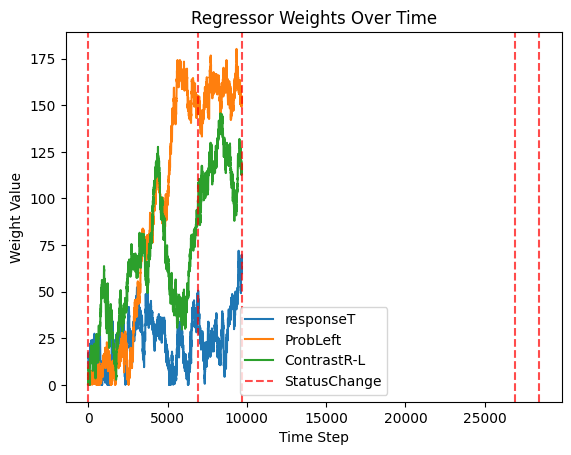

In [77]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

file_path = "D:/Neuro/AggTS_NYU56.csv" 
data_df = pd.read_csv(file_path)

feature_names = data_df.columns[:-1]
change_points = data_df.index[data_df['StatusChange'] == 1].tolist()

for regressor_idx in range(dynamic_glm.n_regressors):
    plt.plot(range(dynamic_glm.T), abs(dynamic_glm.weights[:, regressor_idx]), label=feature_names[regressor_idx])

for change_point in change_points:
    plt.axvline(x=change_point, color='red', linestyle='--', alpha=0.7, 
                label='StatusChange' if change_point == change_points[0] else None)
    
#for change_point in change_points:
    #plt.axvline(x=change_point, color='red', linestyle='--', alpha=0.7, label='Change Point' if change_point == change_points[0] else None)

plt.title("Regressor Weights Over Time")
plt.xlabel("Time Step")
plt.ylabel("Weight Value")
plt.legend()
plt.show()

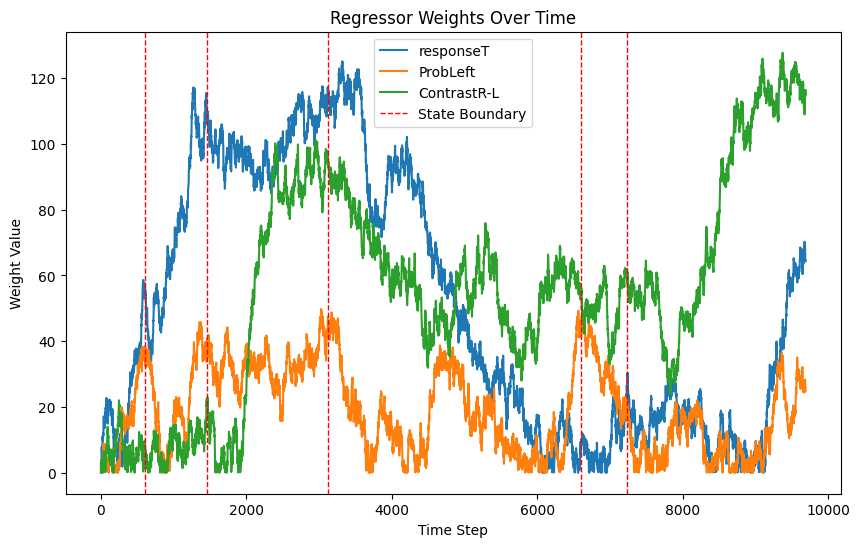

In [107]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import find_peaks

file_path = "D:/Neuro/AggTS_NYU56.csv" 
data_df = pd.read_csv(file_path)

feature_names = data_df.columns[:-1]

# sum of abs
total_weights = np.sum(np.abs(dynamic_glm.weights), axis=1)

# Change point
peaks, _ = find_peaks(total_weights, prominence=40) 

plt.figure(figsize=(10, 6))
for regressor_idx in range(dynamic_glm.n_regressors):
    plt.plot(range(dynamic_glm.T), abs(dynamic_glm.weights[:, regressor_idx]), label=feature_names[regressor_idx])

# Boundary
for peak in peaks:
    plt.axvline(x=peak, color='red', linestyle='--', linewidth=1, label='State Boundary' if peak == peaks[0] else "")

plt.title("Regressor Weights Over Time")
plt.xlabel("Time Step")
plt.ylabel("Weight Value")
plt.legend()
plt.show()


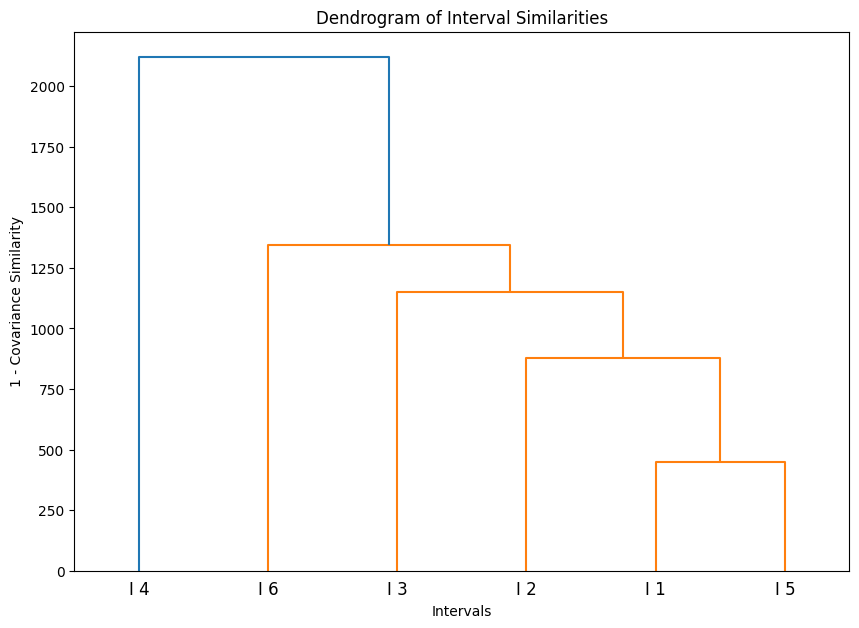

In [108]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.interpolate import interp1d

file_path = "D:/Neuro/AggTS_NYU56.csv" 
data_df = pd.read_csv(file_path)
data_df.iloc[:, 3] = 0.5 * (data_df.iloc[:, 3] + 1)
feature_names = data_df.columns[:-1]

# Calculate total weights
absolute_weights = np.abs(dynamic_glm.weights)
total_weights = np.sum(absolute_weights, axis=1)

# Find change points based on prominence
peaks, _ = find_peaks(total_weights, prominence=40) 

# Include boundaries for entire range
extended_peaks = np.concatenate(([0], peaks, [dynamic_glm.T]))

# Interpolate intervals to equal length
def interpolate_to_equal_length(interval, target_length):
    x = np.linspace(0, 1, len(interval))
    f = interp1d(x, interval, axis=0, kind='linear', fill_value="extrapolate")
    return f(np.linspace(0, 1, target_length))

# Compute covariance similarity
def compute_covariance_similarity(interval1, interval2):
    interpolated1 = interpolate_to_equal_length(interval1, len(interval2))
    cov_matrix = np.cov(interpolated1.T, interval2.T, bias=True)
    return np.sum(np.diag(cov_matrix[:interval1.shape[1], interval1.shape[1]:]))

# Gather intervals
intervals = [absolute_weights[start:end] for start, end in zip(extended_peaks[:-1], extended_peaks[1:])]

# Compute pairwise similarities
num_intervals = len(intervals)
similarity_matrix = np.zeros((num_intervals, num_intervals))

for i in range(num_intervals):
    for j in range(i + 1, num_intervals):
        similarity = compute_covariance_similarity(intervals[i], intervals[j])
        similarity_matrix[i, j] = similarity
        similarity_matrix[j, i] = similarity

# Perform hierarchical clustering
linkage_matrix = linkage(1 - similarity_matrix, method='ward')

# Plot dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=[f'I {i + 1}' for i in range(num_intervals)])
plt.title("Dendrogram of Interval Similarities")
plt.xlabel("Intervals")
plt.ylabel("1 - Covariance Similarity")
plt.show()


In [109]:
peaks

array([ 601, 1465, 3119, 6603, 7239], dtype=int64)

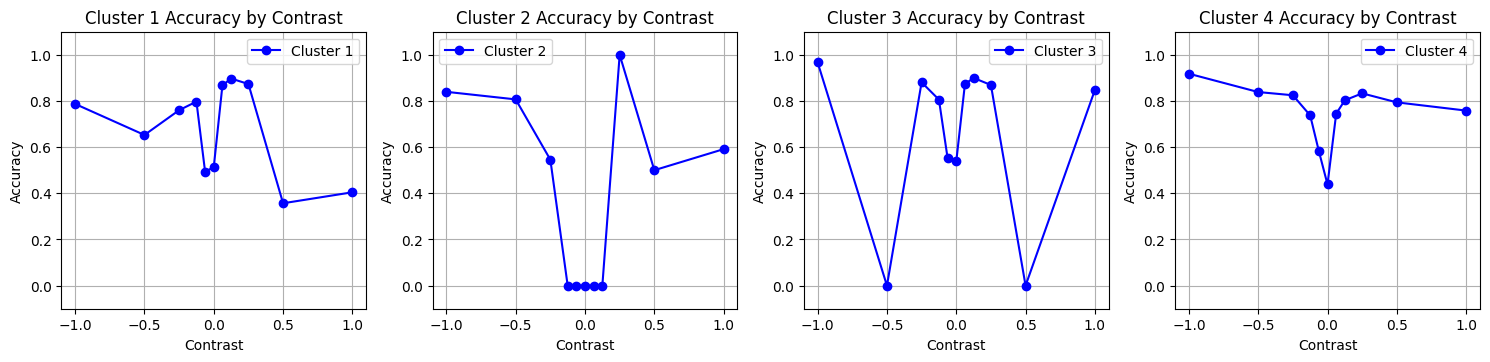

In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster
from collections import defaultdict

# Number of clusters
num_clusters = 4

# Assign clusters based on the dendrogram result
clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Extract contrast and performance data
time_indices = np.arange(len(data_df))
contrast = data_df.iloc[:, 2].values
performance = data_df.iloc[:, 3].values

# Store time intervals for each cluster
cluster_time_intervals = defaultdict(list)

# Collect time intervals corresponding to clusters
for idx, cluster_id in enumerate(clusters):
    cluster_time_intervals[cluster_id].extend(time_indices[extended_peaks[idx]:extended_peaks[idx+1]])

# Function to calculate accuracy for each contrast
def calculate_accuracy(contrast, performance, unique_contrasts):
    accuracy = []
    for value in unique_contrasts:
        relevant_indices = np.where(contrast == value)[0]
        correct = np.sum(performance[relevant_indices])
        total = len(relevant_indices)
        accuracy.append(correct / total if total > 0 else 0)
    return accuracy

# Find all unique contrasts globally
all_unique_contrasts = np.unique(contrast)

# Store unique contrasts and counts per cluster
cluster_contrast_counts = defaultdict(list)

# Plot accuracy curves for each cluster
plt.figure(figsize=(15, 10))

for cluster_id in range(1, num_clusters + 1):
    time_points = cluster_time_intervals[cluster_id]
    cluster_contrast = contrast[time_points]
    cluster_performance = performance[time_points]

    # Calculate unique contrasts and counts
    unique_contrasts, counts = np.unique(cluster_contrast, return_counts=True)
    cluster_contrast_counts[cluster_id] = list(zip(unique_contrasts, counts))

    # Calculate accuracy using global unique contrasts
    accuracy_values = calculate_accuracy(cluster_contrast, cluster_performance, all_unique_contrasts)

    # Plot accuracy line
    plt.subplot(3, 4, cluster_id)
    plt.plot(all_unique_contrasts, accuracy_values, marker='o', color='b', label=f'Cluster {cluster_id}')
    plt.title(f'Cluster {cluster_id} Accuracy by Contrast')
    plt.xlim(-1.1,1.1)
    plt.ylim(-0.1,1.1)
    plt.xlabel('Contrast')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()


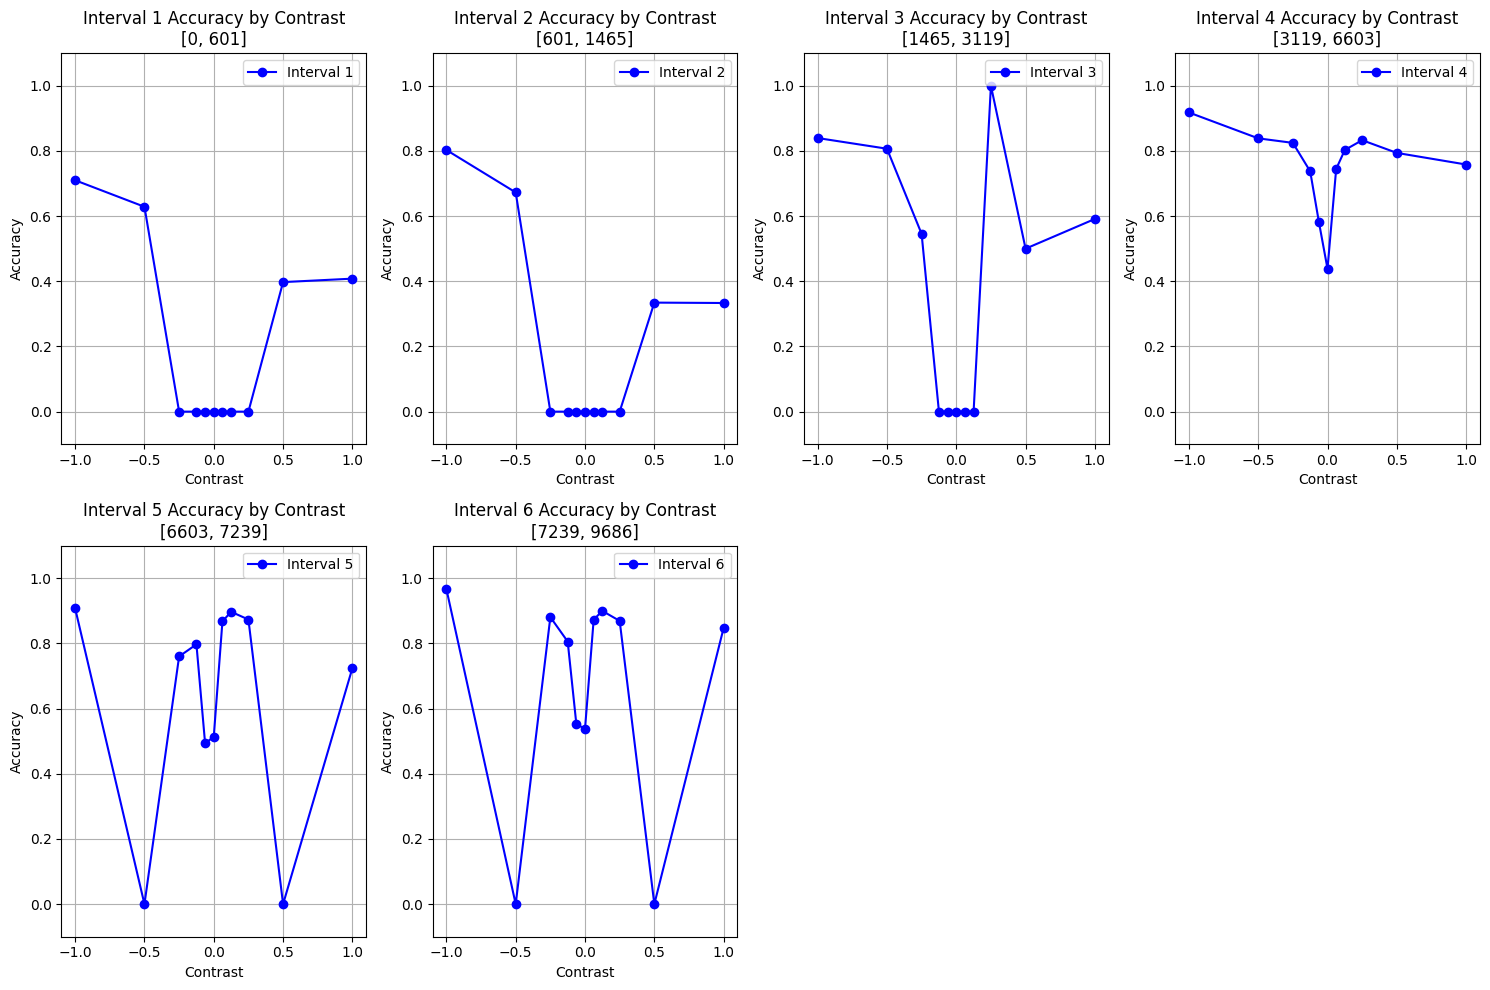


Interval Information:
Interval 1: [0, 601]
Interval 2: [601, 1465]
Interval 3: [1465, 3119]
Interval 4: [3119, 6603]
Interval 5: [6603, 7239]
Interval 6: [7239, 9686]


In [111]:
#no recluster
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# Extract contrast and performance data
time_indices = np.arange(len(data_df))
contrast = data_df.iloc[:, 2].values
performance = data_df.iloc[:, 3].values

# Store time intervals
interval_time_points = defaultdict(list)

# Collect time points corresponding to each interval
# 使用extended_peaks直接定义intervals
num_intervals = len(extended_peaks) - 1
for interval_id in range(num_intervals):
    start = extended_peaks[interval_id]
    end = extended_peaks[interval_id + 1]
    interval_time_points[interval_id + 1].extend(time_indices[start:end])

# Function to calculate accuracy for each contrast
def calculate_accuracy(contrast, performance, unique_contrasts):
    accuracy = []
    for value in unique_contrasts:
        relevant_indices = np.where(contrast == value)[0]
        correct = np.sum(performance[relevant_indices])
        total = len(relevant_indices)
        accuracy.append(correct / total if total > 0 else 0)
    return accuracy

# Find all unique contrasts globally
all_unique_contrasts = np.unique(contrast)

# Store unique contrasts and counts per interval
interval_contrast_counts = defaultdict(list)

# Calculate number of subplot rows and columns
n_rows = (num_intervals + 3) // 4  # Ceiling division by 4
n_cols = min(4, num_intervals)

# Plot accuracy curves for each interval
plt.figure(figsize=(15, 10))
for interval_id in range(1, num_intervals + 1):
    time_points = interval_time_points[interval_id]
    interval_contrast = contrast[time_points]
    interval_performance = performance[time_points]
    
    # Calculate unique contrasts and counts
    unique_contrasts, counts = np.unique(interval_contrast, return_counts=True)
    interval_contrast_counts[interval_id] = list(zip(unique_contrasts, counts))
    
    # Calculate accuracy using global unique contrasts
    accuracy_values = calculate_accuracy(interval_contrast, interval_performance, all_unique_contrasts)
    
    # Plot accuracy line
    plt.subplot(n_rows, n_cols, interval_id)
    plt.plot(all_unique_contrasts, accuracy_values, marker='o', color='b', label=f'Interval {interval_id}')
    plt.title(f'Interval {interval_id} Accuracy by Contrast\n[{extended_peaks[interval_id-1]}, {extended_peaks[interval_id]}]')
    plt.xlim(-1.1, 1.1)
    plt.ylim(-0.1, 1.1)
    plt.xlabel('Contrast')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

# Print interval information
print("\nInterval Information:")
for interval_id in range(1, num_intervals + 1):
    start = extended_peaks[interval_id-1]
    end = extended_peaks[interval_id]
    print(f"Interval {interval_id}: [{start}, {end}]")

In [87]:

# Print unique contrasts and counts per cluster
for cluster_id, counts in cluster_contrast_counts.items():
    print(f"Cluster {cluster_id} Unique Contrasts and Counts:")
    for contrast_value, count in counts:
        print(f"  Contrast: {contrast_value}, Count: {count}")

Cluster 1 Unique Contrasts and Counts:
  Contrast: -1.0, Count: 207
  Contrast: -0.5, Count: 120
  Contrast: -0.25, Count: 217
  Contrast: -0.125, Count: 84
  Contrast: -0.0625, Count: 85
  Contrast: 0.0, Count: 100
  Contrast: 0.0625, Count: 105
  Contrast: 0.125, Count: 78
  Contrast: 0.25, Count: 225
  Contrast: 0.5, Count: 130
  Contrast: 1.0, Count: 239
Cluster 2 Unique Contrasts and Counts:
  Contrast: -1.0, Count: 47
  Contrast: -0.5, Count: 41
  Contrast: -0.25, Count: 42
  Contrast: -0.125, Count: 34
  Contrast: -0.0625, Count: 39
  Contrast: 0.0, Count: 31
  Contrast: 0.0625, Count: 50
  Contrast: 0.125, Count: 42
  Contrast: 0.25, Count: 43
  Contrast: 0.5, Count: 39
  Contrast: 1.0, Count: 44
Cluster 3 Unique Contrasts and Counts:
  Contrast: -1.0, Count: 237
  Contrast: -0.5, Count: 241
  Contrast: -0.25, Count: 95
  Contrast: -0.125, Count: 23
  Contrast: 0.125, Count: 26
  Contrast: 0.25, Count: 127
  Contrast: 0.5, Count: 188
  Contrast: 1.0, Count: 154
Cluster 4 Unique

In [41]:
len(np.unique(data_df.iloc[:, 2].values))

11

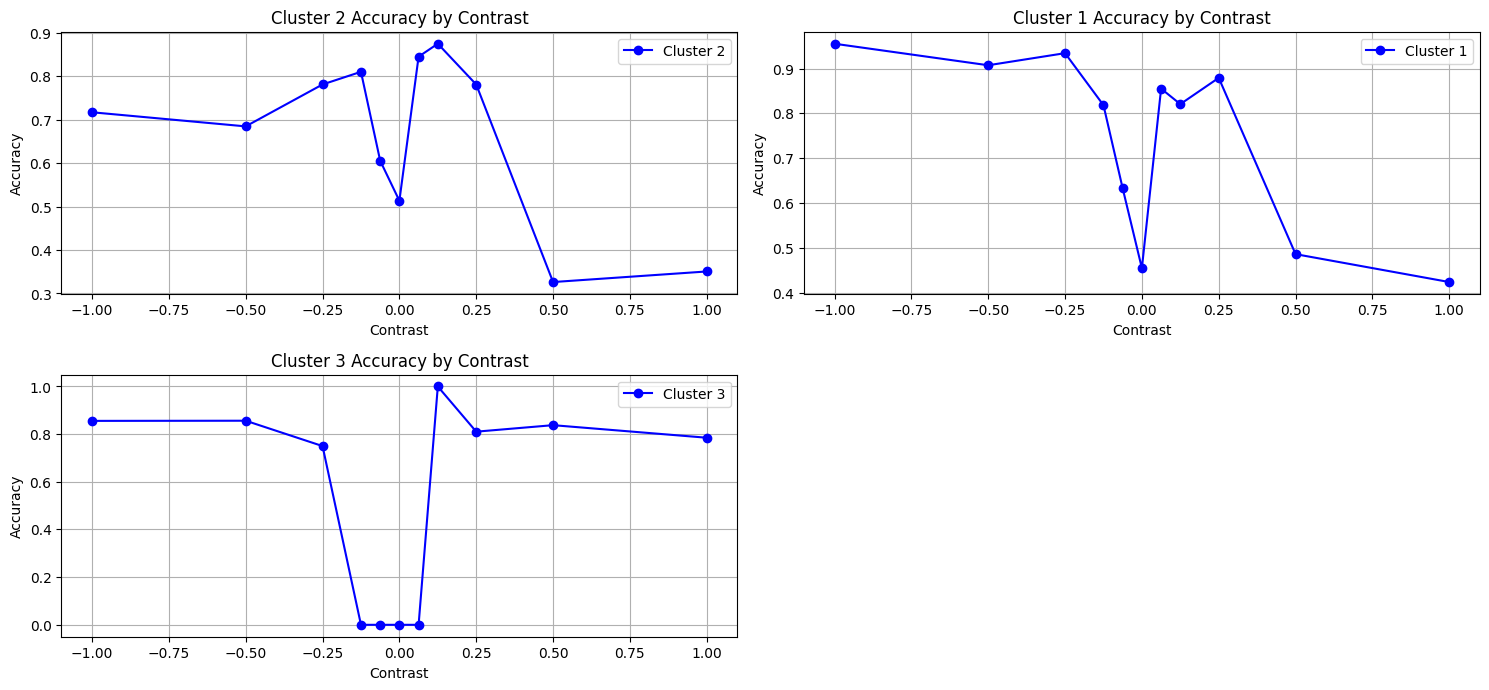

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster
from collections import defaultdict

# Number of clusters
num_clusters = 3

# Assign clusters based on the dendrogram result
clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Extract contrast and performance data
time_indices = np.arange(len(data_df))
contrast = data_df.iloc[:, 2].values
performance = data_df.iloc[:, 3].values

# Store time intervals for each cluster
cluster_time_intervals = defaultdict(list)

# Collect time intervals corresponding to clusters
for idx, cluster_id in enumerate(clusters):
    cluster_time_intervals[cluster_id].extend(time_indices[extended_peaks[idx]:extended_peaks[idx+1]])

# Function to calculate accuracy for each contrast
def calculate_accuracy(contrast, performance, unique_contrasts):
    accuracy = []
    for value in unique_contrasts:
        relevant_indices = np.where(contrast == value)[0]
        correct = np.sum(performance[relevant_indices])
        total = len(relevant_indices)
        accuracy.append(correct / total if total > 0 else 0)
    return accuracy

# Find all unique contrasts globally
all_unique_contrasts = np.unique(contrast)

# Store unique contrasts and counts per cluster
cluster_contrast_counts = defaultdict(list)

# Find earliest element time per cluster
earliest_times = {cluster_id: min(time_points) for cluster_id, time_points in cluster_time_intervals.items()}
sorted_clusters = sorted(earliest_times.keys(), key=lambda x: earliest_times[x])

# Plot accuracy curves for each cluster
plt.figure(figsize=(15, 10))

for plot_idx, cluster_id in enumerate(sorted_clusters, 1):
    time_points = cluster_time_intervals[cluster_id]
    cluster_contrast = contrast[time_points]
    cluster_performance = performance[time_points]

    # Calculate unique contrasts and counts
    unique_contrasts, counts = np.unique(cluster_contrast, return_counts=True)
    cluster_contrast_counts[cluster_id] = list(zip(unique_contrasts, counts))

    # Calculate accuracy using global unique contrasts
    accuracy_values = calculate_accuracy(cluster_contrast, cluster_performance, all_unique_contrasts)

    # Plot accuracy line
    plt.subplot(3, 2, plot_idx)
    plt.plot(all_unique_contrasts, accuracy_values, marker='o', color='b', label=f'Cluster {cluster_id}')
    plt.title(f'Cluster {cluster_id} Accuracy by Contrast')
    plt.xlabel('Contrast')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()


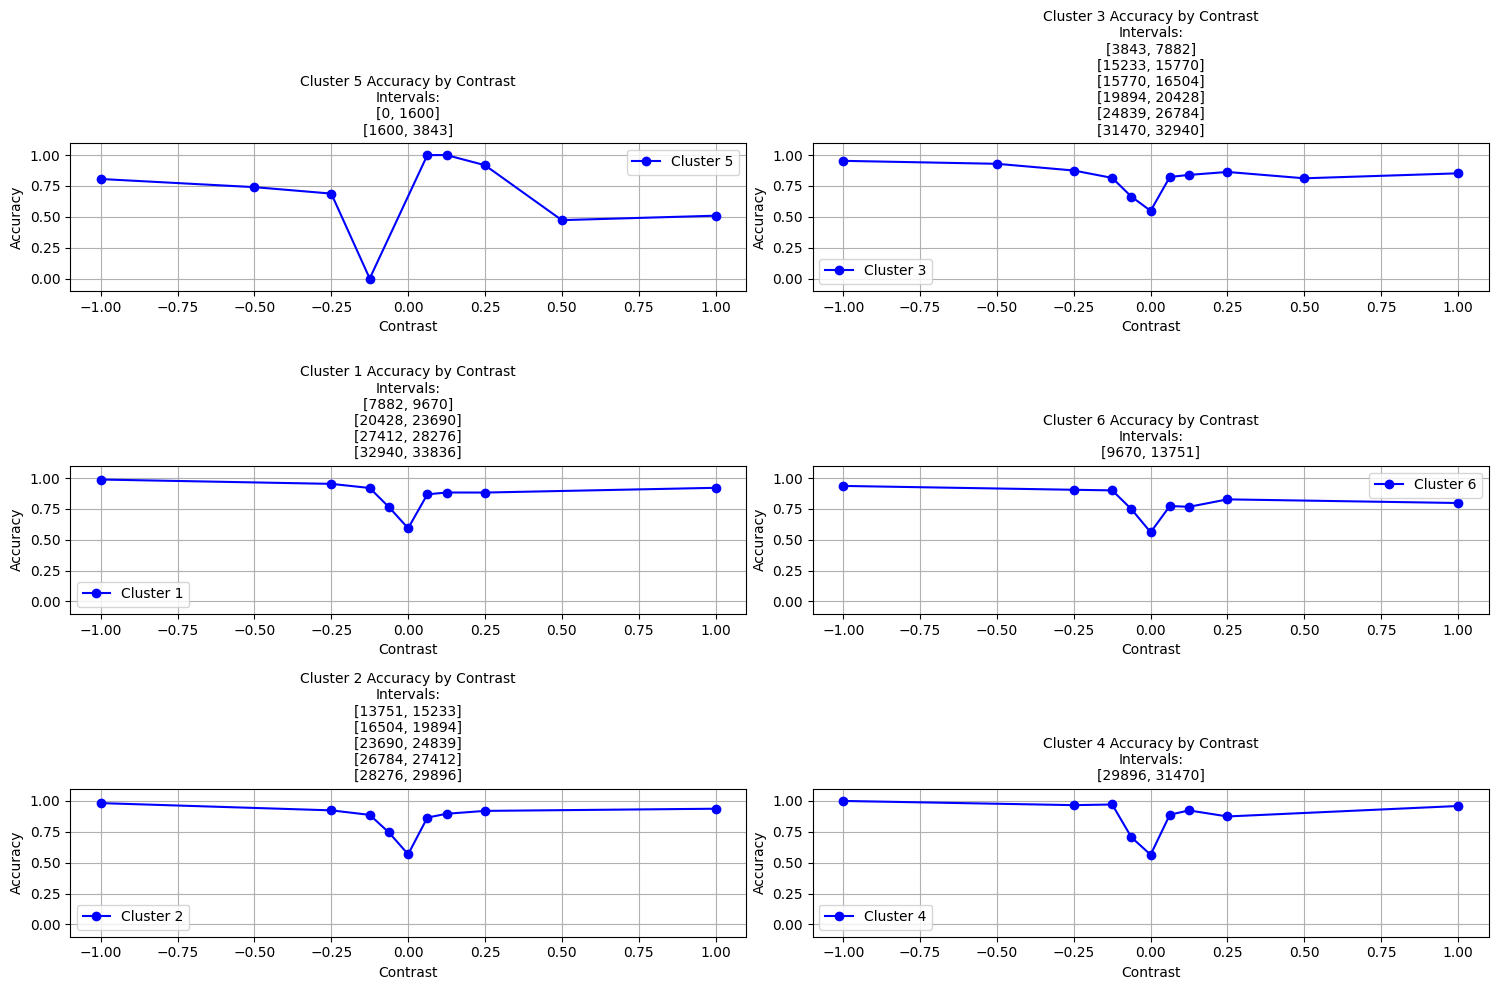

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster
from collections import defaultdict

# Number of clusters
num_clusters = 6

# Assign clusters based on the dendrogram result
clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Extract contrast and performance data
time_indices = np.arange(len(data_df))
contrast = data_df.iloc[:, 2].values
performance = data_df.iloc[:, 3].values

# Store time intervals for each cluster
cluster_time_intervals = defaultdict(list)
original_intervals = defaultdict(list)

# Collect time intervals corresponding to clusters
for idx, cluster_id in enumerate(clusters):
    start, end = extended_peaks[idx], extended_peaks[idx+1]
    cluster_time_intervals[cluster_id].extend(time_indices[start:end])
    original_intervals[cluster_id].append((start, end))

# Function to calculate accuracy for each contrast
def calculate_accuracy(contrast, performance, unique_contrasts):
    accuracy = []
    for value in unique_contrasts:
        relevant_indices = np.where(contrast == value)[0]
        correct = np.sum(performance[relevant_indices])
        total = len(relevant_indices)
        accuracy.append(correct / total if total > 0 else np.nan)
    return accuracy

# Find all unique contrasts globally
all_unique_contrasts = np.unique(contrast)

# Store unique contrasts and counts per cluster
cluster_contrast_counts = defaultdict(list)

# Find earliest element time per cluster
earliest_times = {cluster_id: min(time_points) for cluster_id, time_points in cluster_time_intervals.items()}
sorted_clusters = sorted(earliest_times.keys(), key=lambda x: earliest_times[x])

# Plot accuracy curves for each cluster
plt.figure(figsize=(15, 10))

for plot_idx, cluster_id in enumerate(sorted_clusters, 1):
    time_points = cluster_time_intervals[cluster_id]
    cluster_contrast = contrast[time_points]
    cluster_performance = performance[time_points]

    # Calculate unique contrasts and counts
    unique_contrasts, counts = np.unique(cluster_contrast, return_counts=True)
    cluster_contrast_counts[cluster_id] = list(zip(unique_contrasts, counts))

    # Calculate accuracy using global unique contrasts
    accuracy_values = calculate_accuracy(cluster_contrast, cluster_performance, all_unique_contrasts)

    # Remove missing contrasts
    valid_indices = ~np.isnan(accuracy_values)
    filtered_contrasts = all_unique_contrasts[valid_indices]
    filtered_accuracies = np.array(accuracy_values)[valid_indices]

    # Adjust interval labels with line breaks
    interval_labels = "\n".join([f"[{start}, {end}]" for start, end in original_intervals[cluster_id]])

    # Plot accuracy line
    plt.subplot(3, 2, plot_idx)
    plt.plot(filtered_contrasts, filtered_accuracies, marker='o', color='b', label=f'Cluster {cluster_id}')
    plt.title(f'Cluster {cluster_id} Accuracy by Contrast\nIntervals:\n{interval_labels}', fontsize=10)
    plt.xlabel('Contrast')
    plt.ylabel('Accuracy')
    plt.xlim(-1.1, 1.1)
    plt.ylim(-0.1, 1.1)
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()


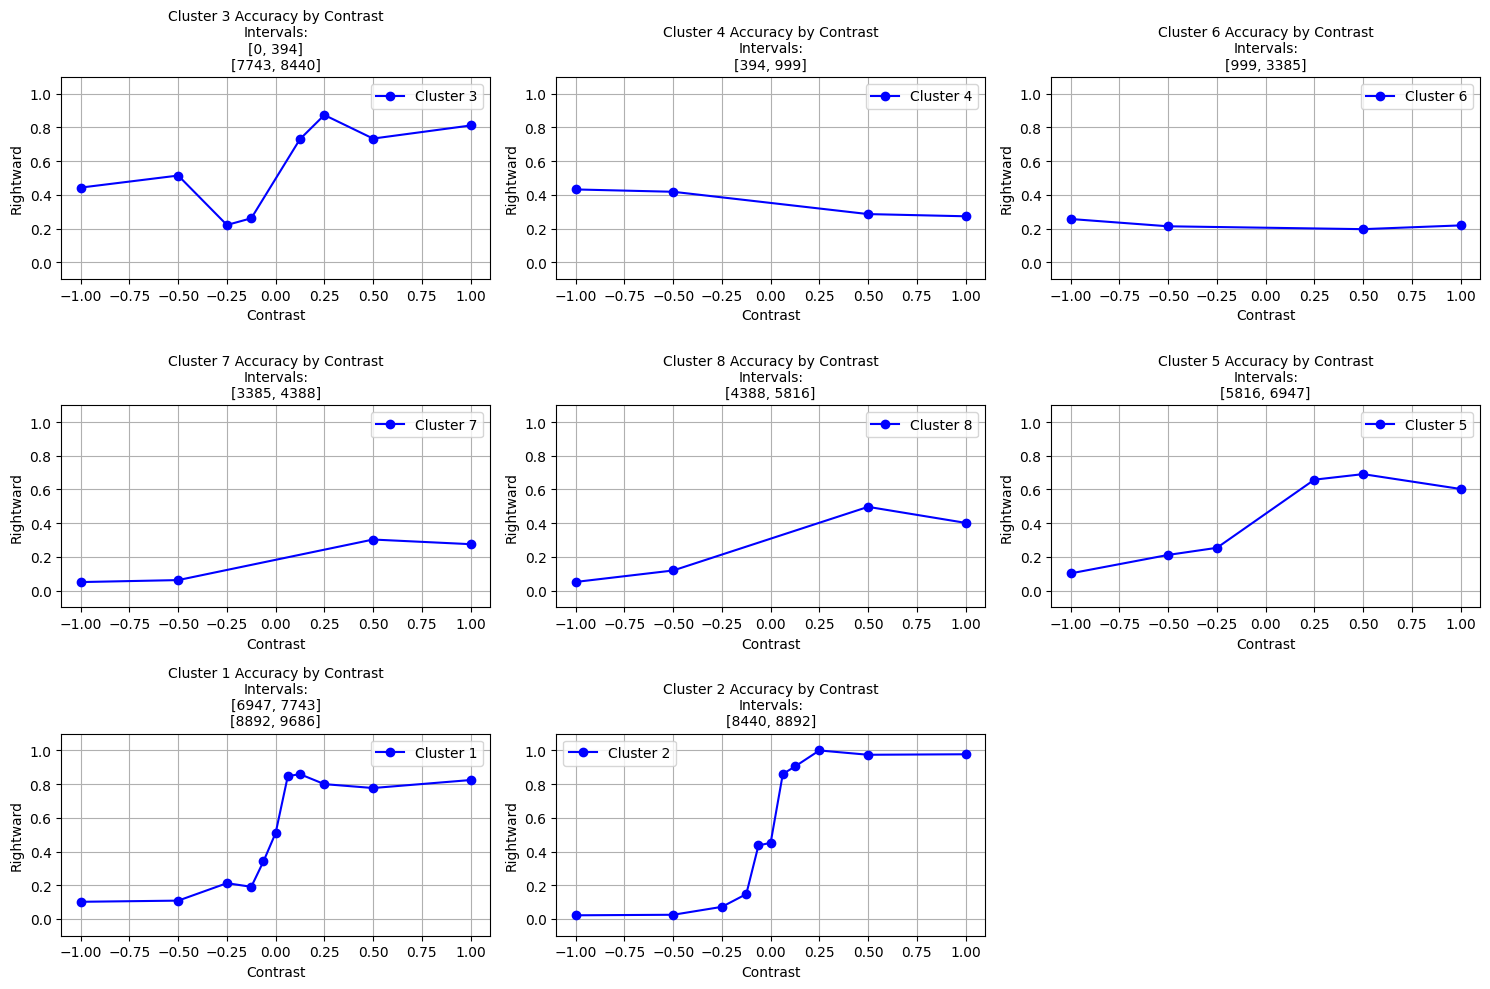

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster
from collections import defaultdict

# Number of clusters
num_clusters = 10
# Assign clusters based on the dendrogram result
clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Extract contrast and performance data
time_indices = np.arange(len(data_df))
contrast = data_df.iloc[:, 2].values
performance = data_df.iloc[:, 3].values

# Store time intervals for each cluster
cluster_time_intervals = defaultdict(list)
original_intervals = defaultdict(list)

# Collect time intervals corresponding to clusters
for idx, cluster_id in enumerate(clusters):
    start, end = extended_peaks[idx], extended_peaks[idx+1]
    cluster_time_intervals[cluster_id].extend(time_indices[start:end])
    original_intervals[cluster_id].append((start, end))

# Function to calculate accuracy for each contrast
def calculate_accuracy(contrast, performance, unique_contrasts):
    accuracy = []
    for value in unique_contrasts:
        relevant_indices = np.where(contrast == value)[0]
        correct = np.sum(performance[relevant_indices])
        total = len(relevant_indices)
        accuracy.append(correct / total if total > 0 else np.nan)
    return accuracy

# Find all unique contrasts globally
all_unique_contrasts = np.unique(contrast)

# Store unique contrasts and counts per cluster
cluster_contrast_counts = defaultdict(list)

# Find earliest element time per cluster
earliest_times = {cluster_id: min(time_points) for cluster_id, time_points in cluster_time_intervals.items()}
sorted_clusters = sorted(earliest_times.keys(), key=lambda x: earliest_times[x])

# Plot accuracy curves for each cluster
plt.figure(figsize=(15, 10))
for plot_idx, cluster_id in enumerate(sorted_clusters, 1):
    time_points = cluster_time_intervals[cluster_id]
    cluster_contrast = contrast[time_points]
    cluster_performance = performance[time_points]
    
    # Calculate unique contrasts and counts
    unique_contrasts, counts = np.unique(cluster_contrast, return_counts=True)
    cluster_contrast_counts[cluster_id] = list(zip(unique_contrasts, counts))
    
    # Calculate accuracy using global unique contrasts
    accuracy_values = calculate_accuracy(cluster_contrast, cluster_performance, all_unique_contrasts)
    
    # Remove missing contrasts
    valid_indices = ~np.isnan(accuracy_values)
    filtered_contrasts = all_unique_contrasts[valid_indices]
    filtered_accuracies = np.array(accuracy_values)[valid_indices]
    
    # Modify accuracy values for negative contrasts
    filtered_accuracies = np.where(filtered_contrasts < 0, 1 - filtered_accuracies, filtered_accuracies)
    
    # Adjust interval labels with line breaks
    interval_labels = "\n".join([f"[{start}, {end}]" for start, end in original_intervals[cluster_id]])
    
    # Plot accuracy line
    plt.subplot(3, 3, plot_idx)
    plt.plot(filtered_contrasts, filtered_accuracies, marker='o', color='b', label=f'Cluster {cluster_id}')
    plt.title(f'Cluster {cluster_id} Accuracy by Contrast\nIntervals:\n{interval_labels}', fontsize=10)
    plt.xlabel('Contrast')
    plt.ylabel('Rightward')  # Changed ylabel to 'Rightward'
    plt.xlim(-1.1, 1.1)
    plt.ylim(-0.1, 1.1)
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

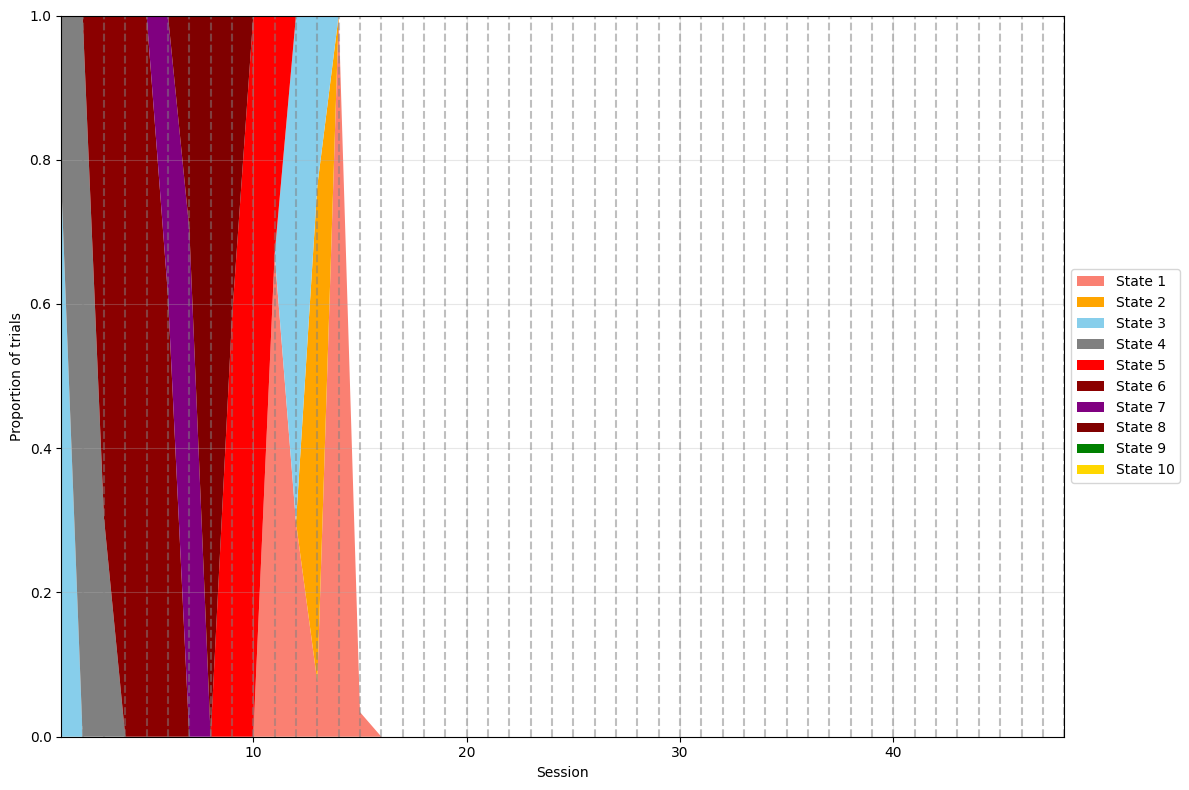

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster
from collections import defaultdict

# 首先，我们需要确保所有数据长度匹配
def get_session_numbers(session_data):
    """Convert session transition markers to session numbers"""
    session_nums = np.zeros_like(session_data, dtype=int)
    current_session = 1
    for i in range(len(session_data)):
        if session_data[i] == 1 and i > 0:  # 如果是转换点且不是第一个点
            current_session += 1
        session_nums[i] = current_session
    return session_nums

# 计算每个session中各个state的比例
def calculate_state_proportions(session_nums, original_intervals, data_length, num_states):
    # 创建一个数组来存储每个时间点属于哪个state
    state_assignments = np.zeros(data_length, dtype=int)
    
    # 根据intervals分配states
    for state_id, intervals_list in original_intervals.items():
        for start, end in intervals_list:
            state_assignments[start:end] = state_id
    
    # 获取唯一的session编号
    unique_sessions = np.unique(session_nums)
    state_proportions = np.zeros((len(unique_sessions), num_states))
    
    # 计算每个session中各个state的比例
    for i, session in enumerate(unique_sessions):
        session_mask = session_nums == session
        session_states = state_assignments[session_mask]
        total_trials = len(session_states)
        
        for state in range(1, num_states + 1):
            state_count = np.sum(session_states == state)
            state_proportions[i, state-1] = state_count / total_trials if total_trials > 0 else 0
            
    return unique_sessions, state_proportions

# 转换session标记为session编号
session_nums = get_session_numbers(data_df.iloc[:, 5].values)

# 计算proportions
unique_sessions, state_proportions = calculate_state_proportions(
    session_nums, 
    original_intervals, 
    len(data_df), 
    num_clusters
)

# 创建堆叠面积图
plt.figure(figsize=(12, 8))

# 定义颜色映射
colors = ['salmon', 'orange', 'skyblue', 'gray', 'red', 'darkred', 'purple', 'maroon', 'green', 'gold']

# 绘制堆叠面积图
plt.stackplot(unique_sessions, 
             [state_proportions[:, i] for i in range(num_clusters)],
             labels=[f'State {i+1}' for i in range(num_clusters)],
             colors=colors[:num_clusters])

# 自定义图形
plt.xlabel('Session')
plt.ylabel('Proportion of trials')
plt.ylim(0, 1)
plt.xlim(min(unique_sessions), max(unique_sessions))
plt.grid(True, alpha=0.3)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# 添加session转换的垂直线
for session in unique_sessions[1:]:
    plt.axvline(x=session, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

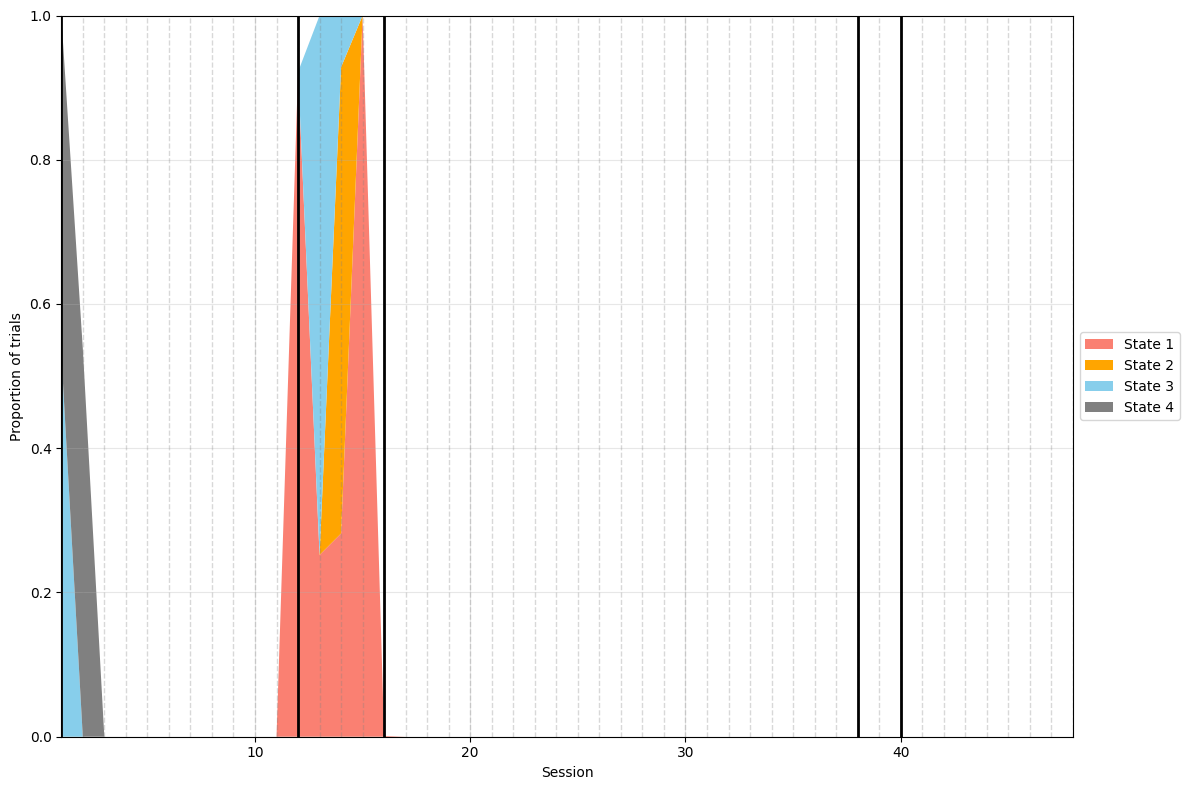

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster
from collections import defaultdict

def get_session_numbers(session_data):
    """Convert session transition markers to session numbers"""
    session_nums = np.zeros_like(session_data, dtype=int)
    current_session = 1
    for i in range(len(session_data)):
        if session_data[i] == 1 and i > 0:
            current_session += 1
        session_nums[i] = current_session
    return session_nums

def calculate_state_proportions(session_nums, original_intervals, data_length, num_states):
    # 创建一个数组来存储每个时间点属于哪个state
    state_assignments = np.zeros(data_length, dtype=int)
    
    # 根据intervals分配states
    for state_id, intervals_list in original_intervals.items():
        for start, end in intervals_list:
            state_assignments[start:end] = state_id
    
    # 获取唯一的session编号
    unique_sessions = np.unique(session_nums)
    state_proportions = np.zeros((len(unique_sessions), num_states))
    
    # 计算每个session中各个state的比例
    for i, session in enumerate(unique_sessions):
        session_mask = session_nums == session
        session_states = state_assignments[session_mask]
        total_trials = len(session_states)
        
        for state in range(1, num_states + 1):
            state_count = np.sum(session_states == state)
            state_proportions[i, state-1] = state_count / total_trials if total_trials > 0 else 0
            
    return unique_sessions, state_proportions

# 获取训练状态改变的session位置
def get_training_change_sessions(session_nums, training_changes):
    change_sessions = []
    for i in range(len(training_changes)):
        if training_changes[i] == 1:
            change_sessions.append(session_nums[i])
    return np.unique(change_sessions)

# 转换session标记为session编号
session_nums = get_session_numbers(data_df.iloc[:, 5].values)

# 获取训练状态改变的session位置
training_changes = data_df.iloc[:, -1].values
training_change_sessions = get_training_change_sessions(session_nums, training_changes)

# 计算proportions
unique_sessions, state_proportions = calculate_state_proportions(
    session_nums, 
    original_intervals, 
    len(data_df), 
    num_clusters
)

# 创建堆叠面积图
plt.figure(figsize=(12, 8))

# 定义颜色映射
colors = ['salmon', 'orange', 'skyblue', 'gray', 'red', 'darkred', 'purple', 'maroon', 'green', 'gold']

# 绘制堆叠面积图
plt.stackplot(unique_sessions, 
             [state_proportions[:, i] for i in range(num_clusters)],
             labels=[f'State {i+1}' for i in range(num_clusters)],
             colors=colors[:num_clusters])

# 添加session转换的细垂直线
for session in unique_sessions[1:]:
    plt.axvline(x=session, color='gray', linestyle='--', alpha=0.3, linewidth=1)

# 添加训练状态改变的粗垂直线
for change_session in training_change_sessions:
    plt.axvline(x=change_session, color='black', linestyle='-', linewidth=2)

# 自定义图形
plt.xlabel('Session')
plt.ylabel('Proportion of trials')
plt.ylim(0, 1)
plt.xlim(min(unique_sessions), max(unique_sessions))
plt.grid(True, alpha=0.3)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [22]:
# 假设你已经加载了 data 和 interval_labels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd


file_path = "D:/Neuro/AggTS_NYU56.csv"
data = pd.read_csv(file_path)

# 假设 data 是一个 DataFrame，包含会话和其他信息
# 假设 cluster_time_intervals 是一个字典，键为 cluster_id，值为时间点区间
# interval_labels 将根据 cluster_id 被重新标记

# 创建 interval_labels，基于 cluster_time_intervals
def generate_interval_labels(cluster_time_intervals):
    interval_labels = []
    for cluster_id, intervals in cluster_time_intervals.items():
        for start, end in intervals:
            interval_labels.extend([cluster_id] * (end - start + 1))
    return np.array(interval_labels)

# 示例：从 cluster_time_intervals 生成 interval_labels
interval_labels = generate_interval_labels(cluster_time_intervals)

# 标记 session 的起始点
data = pd.DataFrame(data, columns=['col1', 'col2', 'col3', 'col4', 'session_flag'])
data['session'] = data['session_flag'].cumsum()

# 创建一个 DataFrame，其中包含状态和会话信息
state_session_df = pd.DataFrame({'state': interval_labels, 'session': data['SessionChange'][:len(interval_labels)]})

# 计算每个状态在每个会话中的比例
state_session_counts = state_session_df.groupby(['session', 'state']).size().reset_index(name='count')
session_totals = state_session_counts.groupby('session')['count'].transform('sum')
state_session_counts['proportion'] = state_session_counts['count'] / session_totals

# 绘制堆叠面积图
plt.figure(figsize=(10, 6))
for state in sorted(state_session_counts['state'].unique()):
    subset = state_session_counts[state_session_counts['state'] == state]
    plt.fill_between(subset['session'], subset['proportion'].cumsum(), label=f'State {state}', alpha=0.8)

plt.title('Proportion of States in Each Session')
plt.xlabel('Session')
plt.ylabel('Proportion of trials')
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


TypeError: cannot unpack non-iterable numpy.int32 object

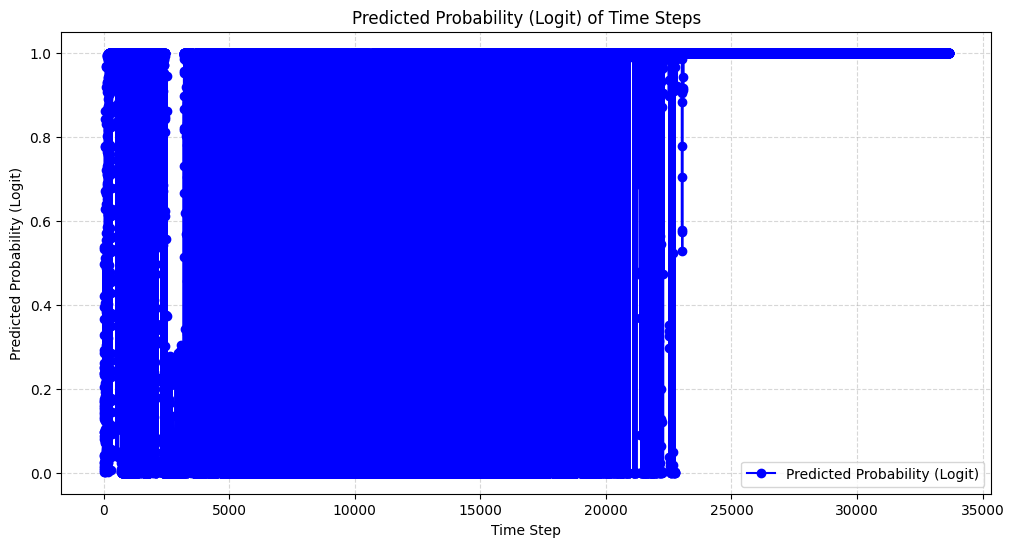

In [67]:
import matplotlib.pyplot as plt
from scipy.special import expit  # Sigmoid function
import numpy as np


time_steps = range(33665)


logit_probs = []


for time_step in time_steps:
    weights = dynamic_glm.weights[time_step]
    features = data[time_step, 0, :-1]  
    logit_prob = expit(np.dot(features, weights))
    logit_probs.append(logit_prob)


plt.figure(figsize=(12, 6))
plt.plot(time_steps, logit_probs, color='b', linestyle='-', marker='o', label="Predicted Probability (Logit)")


plt.title("Predicted Probability (Logit) of Time Steps")
plt.xlabel("Time Step")
plt.ylabel("Predicted Probability (Logit)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [3]:
data_df.loc[data_df.iloc[:, 2].isin([0.5, -0.5])].groupby(data_df.iloc[:, 2]).apply(lambda x: x.index.max())


ContrastR-L
-0.5    8920
 0.5    8862
dtype: int64

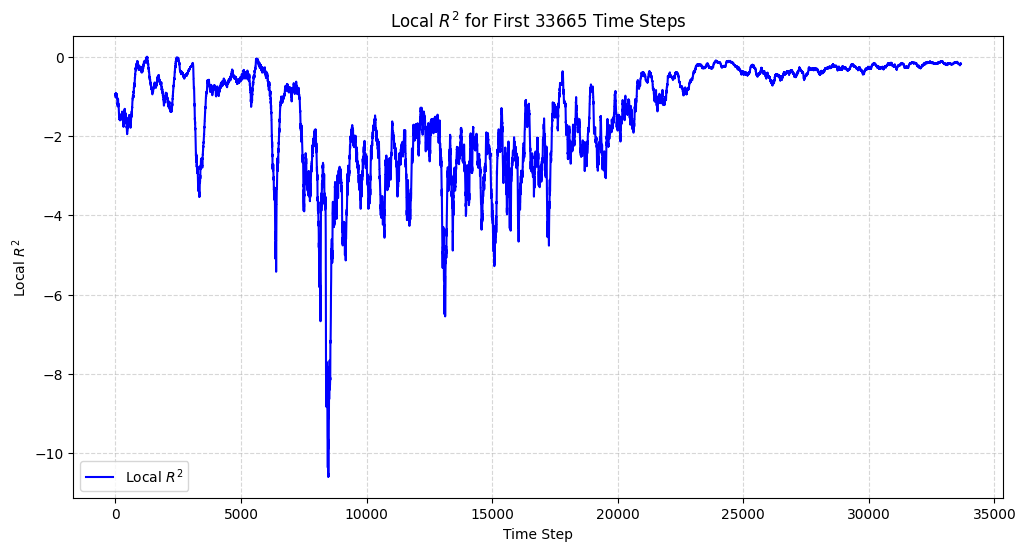

In [51]:
import matplotlib.pyplot as plt
from scipy.special import expit  # Sigmoid function
import numpy as np


window_size = 100


time_steps = range(33665)


local_r2 = []


for time_step in time_steps:
    
    weights = dynamic_glm.weights[time_step]
    features = data[time_step, 0, :-1]  
    y_actual = data[time_step, 0, -1]  
    
    
    y_pred = expit(np.dot(features, weights))

    # local R^2
    start = max(0, time_step - window_size)
    end = min(33665, time_step + window_size + 1)
    
    y_actual_window = data[start:end, 0, -1]
    y_pred_window = [round(expit(np.dot(data[t, 0, :-1], dynamic_glm.weights[t]))) for t in range(start, end)]

    
    ss_total = np.sum((y_actual_window - np.mean(y_actual_window)) ** 2)
    ss_residual = np.sum((y_actual_window - y_pred_window) ** 2)
    
    r2 = 1 - (ss_residual / (ss_total))
    local_r2.append(r2)


plt.figure(figsize=(12, 6))
plt.plot(time_steps, local_r2, color='b', linestyle='-', label="Local $R^2$")


plt.title("Local $R^2$ for First 33665 Time Steps")
plt.xlabel("Time Step")
plt.ylabel("Local $R^2$")
#plt.ylim(-3, 1)  
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

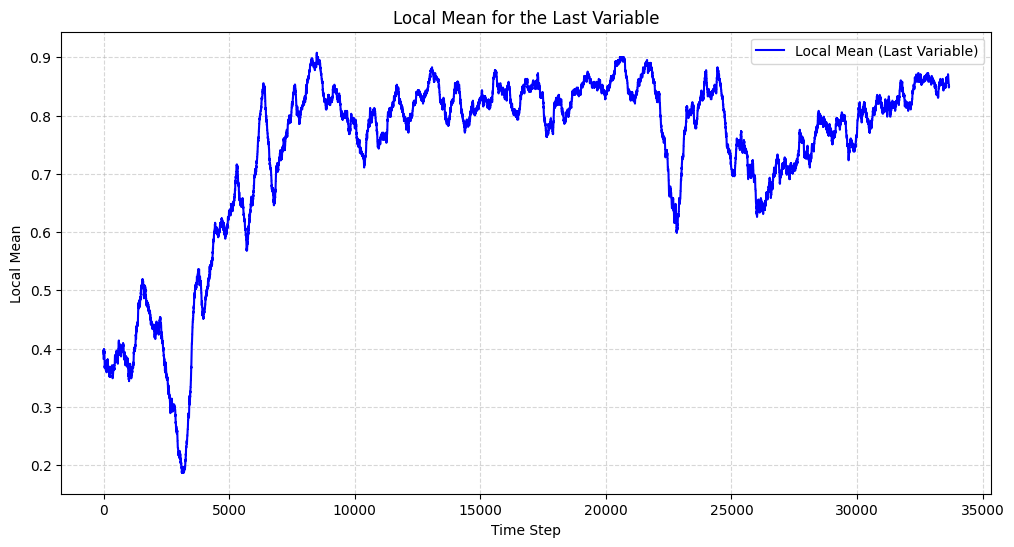

In [53]:
import matplotlib.pyplot as plt
import numpy as np

def plot_local_mean(data, window_size=200):
    """
    local mean of response
    """


    last_variable = data[:, 0, -1]

    
    local_means = []
    time_steps = range(len(last_variable))

    for t in time_steps:
        start = max(0, t - window_size)
        end = min(len(last_variable), t + window_size + 1)
        local_mean = np.nanmean(last_variable[start:end])
        local_means.append(local_mean)

    
    plt.figure(figsize=(12, 6))
    plt.plot(time_steps, local_means, color='b', linestyle='-', label="Local Mean (Last Variable)")

    
    plt.title("Local Mean for the Last Variable")
    plt.xlabel("Time Step")
    plt.ylabel("Local Mean")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


plot_local_mean(data)

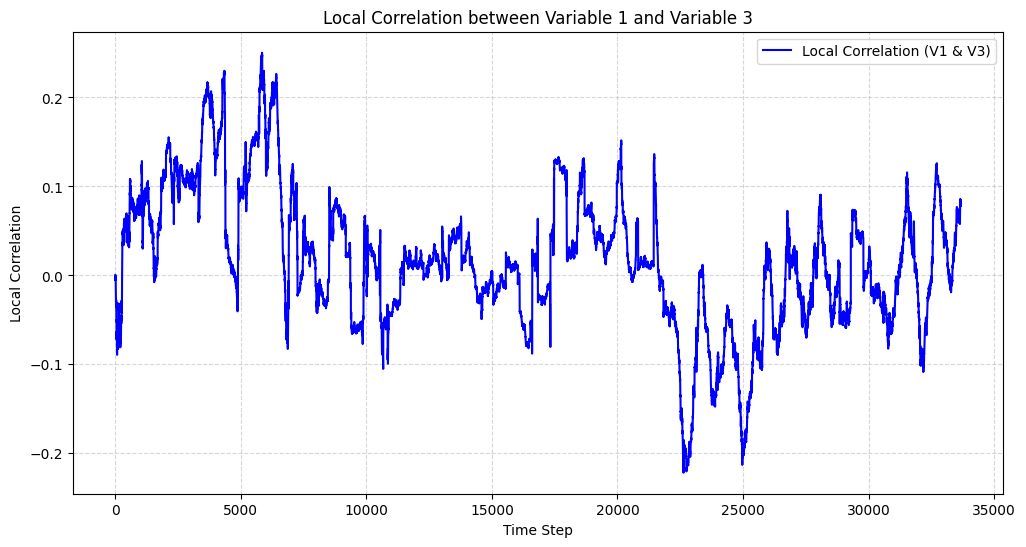

In [63]:
import matplotlib.pyplot as plt
import numpy as np

def plot_local_correlation(data, window_size=250):
    """
    local correlation of variables
    """
    
    col1 = data[:, :, 0]  
    col3 = abs(data[:, :, 2])  

    local_correlations = []
    time_steps = range(data.shape[0]) 

    for t in time_steps:
        start = max(0, t - window_size)
        end = min(len(col1), t + window_size + 1)

       
        correlation_matrix = np.corrcoef(col1[start:end].flatten(), col3[start:end].flatten())
        local_corr = correlation_matrix[0, 1]  
        local_correlations.append(local_corr)

    plt.figure(figsize=(12, 6))
    plt.plot(time_steps, local_correlations, color='b', linestyle='-', label="Local Correlation (V1 & V3)")

    plt.title("Local Correlation between Variable 1 and Variable 3")
    plt.xlabel("Time Step")
    plt.ylabel("Local Correlation")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


plot_local_correlation(data)
